In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy.special import erfinv
from scipy.integrate import quad
from numpy import matrix
import scipy.optimize as Minim
from iminuit import Minuit


In [2]:
class Linear:
    def __init__(self, xmin = 0., xmax = 20., inter = 20., slope = -1.):
        self.xmin = xmin
        self.xmax = xmax
        self.inter = inter
        self.slope = slope
        self.mass = np.array([])
        
    def evaluate(self,x):
        return self.inter + self.slope * x
    
    def fn(self,x):
        return lambda x: self.inter + self.slope * x
        
        
    def maxval(self):
        if(slope<0):
            return self.evaluate(self.xmin)
        else:
            return self.evaluate(self.xmax)
        
    def integral(self,a,b):
        return quad(self.evaluate,a,b)
    
    def next(self):
        do = True
        while(do):
            x0 = np.random.uniform(self.xmin,self.xmax)
            y1 = self.evaluate(x0)
            maxvalue = self.maxval()
            y2 = np.random.uniform(0,maxvalue)
            if(y2<y1):
                filt_x = x0
                mass = np.append(self.mass,filt_x)
                return filt_x
    def setParams(self, xmin,xmax,inter,slope):
        self.xmin = xmin
        self.xmax = xmax
        self.inter = inter
        self.slope = slope
            
class Gaussian:
    def __init__(self,mean, sigma):
        self.mean = mean
        self.sigma = sigma
        self.mass = np.array([])
    
    def evaluate(self, x):
        return np.exp(-0.5*((x-self.mean)/self.sigma)**2)

    def fn(self,x):
        return lambda x:np.exp(-0.5*((x-self.mean)/self.sigma)**2)
    
    def next(self):
        return np.random.normal(self.mean,self.sigma)
    
    def integral(self,a,b):
        return quad(self.evaluate,a,b)
        
        
    
class SignalWithBackground:
    def __init__(self, mean, sigma, sig_fraction,intercept,slope,xmin,xmax):
        self.signal = Gaussian(mean,sigma)
        self.background = Linear(xmin,xmax,intercept,slope)
        self.sig_fraction = sig_fraction
        self.mass_sig = self.signal.mass
        self.mass_bgd = self.background.mass
        self.mass = np.array([])
     
    def next(self):
        q = np.random.uniform ()
        if ( q < self . sig_fraction ):
        # if here , we will draw x from signal distribution
            filt_x = self.signal.next()
            self.mass_sig = np.append(self.mass_sig,filt_x)
        else :
        # if here , we will draw x from background distribuion
            filt_x = self.background.next()
            self.mass_bgd = np.append(self.mass_bgd,filt_x)
        self.mass = np.append(self.mass, filt_x )
        return filt_x
        
        
        

In [3]:
# Main code to generate and plot a single experiment
def singleToy ( nevents_sig = 300 , nevents_bgd = 10000,fname = 'Ex.pdf'):
    sig_fraction = nevents_sig /( nevents_bgd + nevents_sig )
    # Create the pdf
    pdf = SignalWithBackground( mean , sigma , sig_fraction , 
                               intercept , slope , XMIN , XMAX )
    for i in range ( nevents_sig + nevents_bgd ): pdf . next ()
    # retrieve the mass values for signal , background and their sum
    data = pdf.mass
    sig_data = pdf.mass_sig
    bgd_data = pdf.mass_bgd
    # plot things on same page
    myRange = ( XMIN , XMAX )
    fig , axs = plt.subplots (3 ,1 , sharex = 'col',figsize = (10,30))
    axs[0].set_title( " Signal distribution ( " + str ( len ( sig_data )) + " entries ) " )
    axs[1].set_title( " Background distribution ( " + str ( len ( bgd_data )) + " entries ) " )
    axs[2].set_title( " Total distribution ( " + str ( len ( data )) + " entries ) " )
    axs[2].set_xlabel('X')
    axs[0].hist(sig_data , bins = NBINS , range = myRange )
    axs[1].hist(bgd_data , bins = NBINS )
    axs[2].hist(data , bins = NBINS )
    fig.tight_layout()
    
    plt.savefig(fname)

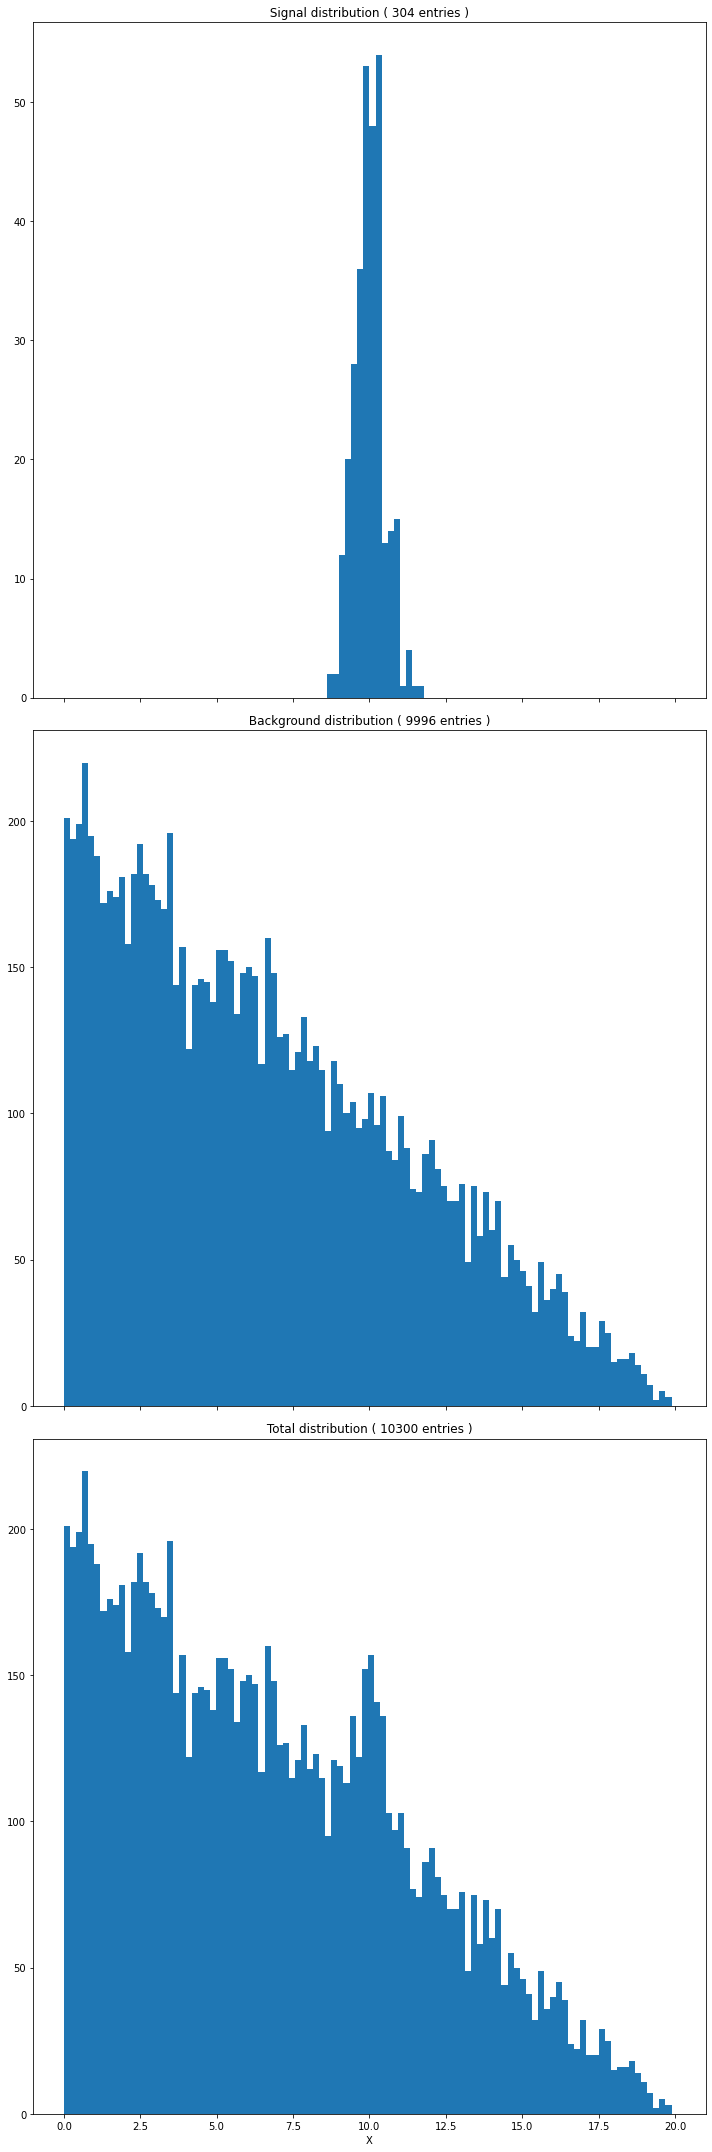

In [4]:
mean = 10.
sigma = 0.5

XMIN = 0.
XMAX = 20.
intercept = 20.
slope = -1.

NBINS = 100

singleToy(nevents_sig = 300, nevents_bgd = 10000,fname = 'Ex3.pdf')

In [5]:
def bgd_analysis(lmb = 10000,k = 10300):
    bgd_model = Gaussian(lmb,np.sqrt(lmb))
    integral_tot = bgd_model.integral(lmb,
                                  np.inf)[0]
    integral_gtk = bgd_model.integral(k,
                                  np.inf)[0]
    pvalue = integral_gtk/integral_tot
    n_sigmas = erfinv(1 - pvalue)*np.sqrt(2)
    return pvalue,n_sigmas


In [6]:
pval,n_sig = bgd_analysis()
print('pval: ',pval,', n sigma: ',n_sig)

pval:  0.002699796063260038 , n sigma:  3.000000000000024


In [7]:
bgd = Linear(XMIN,XMAX,intercept,slope)
def bgd_expected_frac(bgd, a,b):
    #expected fraction in range a,b
    return bgd.integral(a,b)[0]/bgd.integral(XMIN,XMAX)[0]

exp_fraction_full = bgd_expected_frac(bgd,0,20)
exp_fraction_full

1.0

In [8]:
exp_fraction_5_15 = bgd_expected_frac(bgd,5,15)
exp_fraction_5_15

0.5

In [9]:
pval,n_sig = bgd_analysis(lmb = 5000, k = 5300)
print('pval: ',pval,', n sigma: ',n_sig)

pval:  2.209049699858093e-05 , n sigma:  4.242640687119869


Greater deviation since less background and more focus on region of signal

In [10]:
def gen_data( nevents_sig = 150 , nevents_bgd = 10000):
    sig_fraction = nevents_sig /( nevents_bgd + nevents_sig )
    # Create the pdf
    pdf = SignalWithBackground( mean , sigma , sig_fraction , 
                               intercept , slope , XMIN , XMAX )
    for i in range ( nevents_sig + nevents_bgd ): pdf.next()
    # retrieve the mass values for signal , background and their sum
    data = pdf.mass
    return data



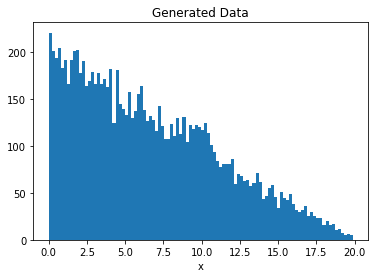

In [11]:
#Generate the data to fit
xdata = gen_data(nevents_sig = 150,nevents_bgd = 10000)
n_obs, xdata, _ = plt.hist(xdata,bins = NBINS)
plt.title('Generated Data')
plt.xlabel('x')
plt.show()

In [12]:
n_obs = np.array(n_obs)
xdata = np.array(xdata)
xdata = (xdata+np.roll(xdata,-1))/2
xdata = xdata[:-1]

print(xdata.shape)
print(n_obs.shape)

(100,)
(100,)


In [13]:
mean = 10.
sigma = 0.5

def lin(x,slope, intercept):
    return slope*x + intercept

def lin_plus_gauss(x, slope, intercept):
    return lin(x,slope,intercept) +  np.exp(-0.5*((x-mean)/sigma)**2)

def cost(n_exp, n_obs):
    return 2*(n_exp - n_obs + n_obs*(np.log(n_obs)-)))


In [14]:
#bgd only fit
def linfitcost(args):
    n_exp = lin(xdata, args[0],args[1])
    res = cost(n_exp,n_obs)
    if(np.sum(res)<0):
        return 1e-3
    return np.sum(res)

minim = Minim.minimize(linfitcost, [1.,1.], method = 'BFGS')
print(minim)


      fun: nan
 hess_inv: array([[ 0.06068568, -0.23885294],
       [-0.23885294,  0.94233639]])
      jac: array([nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 339
      nit: 2
     njev: 113
   status: 2
  success: False
        x: array([-6504.4387239 , 25798.41643472])


C:\Users\Sahaj Porwal\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sahaj Porwal\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sahaj Porwal\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Coming across an issue with this code(undefined values in logarithm), unsure how to correct.

Overall thought process here is using the chisq equivalent LL function to fit the simple linear function.

In [15]:
#bgd+signal fit
def fullfitcost(args):
    n_exp = lin_plus_gauss(xdata, args[0],args[1])
    res = cost(n_exp,n_obs)
    if(np.sum(res)<0):
        return 1e-3
    return np.sum(res)

minim = Minim.minimize(fullfitcost, [1.,1.], method = 'BFGS')
print(minim)

      fun: nan
 hess_inv: array([[ 0.06152031, -0.24038205],
       [-0.24038205,  0.94148774]])
      jac: array([nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 339
      nit: 2
     njev: 113
   status: 2
  success: False
        x: array([-6576.8682428 , 25897.69751317])


C:\Users\Sahaj Porwal\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sahaj Porwal\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sahaj Porwal\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Coming across an issue with this code(undefined values in logarithm), unsure how to correct.

Overall thought process here is using the chisq equivalent LL function to this time fit the composite function with linear and gaussian parts.

These values would then be used to determined the different to then get the p-value and Z score